# MHW Calculation and Satellite Climatology

This notebook computes the MHW event statistics as a Python dictionary. It also generates a netcdf of the climtology and threshold values for each of the pixels in the CBay.

- Geo-Polar
- MUR
- OSTIA

- All: identify MHW, save climatology output
- Extras for just Geo-Polar: save event statistics, save threshold output, compute detrended sst and use to identify MHW

Explain dask -- uncomment dask lines (ex. Client()) to use dask backend. Not needed for small datasets, but should speed up processing.

**QUESTION** do we ever use the threshold information? Maybe it doesn't need to be saved (probably not for MUR/OSTIA, but maybe not for geopolar, either?)

In [1]:
import os
import pickle
from typing import Union
import collections
from datetime import datetime, date

import xarray as xr
import numpy as np
from scipy import stats
import pandas as pd
import dask.array as da
from dask.distributed import Client
import marineHeatWaves as mhw

In [2]:
REPO_ROOT = os.getenv('REPO_ROOT', '/Users/rwegener/repos/chesapeake_mhw')

In [3]:
# Folder in which to store processed climatologies and thresholds
OUTPUT_DIR = os.path.join(REPO_ROOT, 'data/interim')

In [4]:
# dask.config.set({'temporary_directory':'/Users/rwegener/repos/'})

client = Client()

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54502,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:54514,Total threads: 2
Dashboard: http://127.0.0.1:54515/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54506,


### Helper functions

The processing in these functions is repeated several times throughout the notebook. That code has been consolidated here and given descriptive names to make reading the notebook easier.

In [6]:
def format_time(time_np: collections.abc.Iterable[Union[datetime, str]]) -> np.ndarray[int]:
    """
    This function converts a datetime string to an ordinal datetime. Ordinal dates
    are required for processing in the marineHeatWaves library.
    Args:
        time_np: an array of datetime strings of the format %Y-%m-%dT%H:%M:%S.000000000

    Returns:
        an array of ordinal dates (ex. 2005156)
    """
    time_dt_list = [datetime.strptime(str(time), '%Y-%m-%dT%H:%M:%S.000000000') 
                    for time in time_np]
    return np.array([time.toordinal() for time in time_dt_list])

In [7]:
def identify_marineheatwaves(sst_np: np.ndarray, time_ordinal: np.ndarray):
    """
    This function uses the marineHeatWave package mhw.detect() and applies it
    to all the pixels in a satellite data image. The output is numpy array of
    the dictionaries that are returned from the mhw.detect() function.

    Args:
        sst_np: a 3D numpy array which gives SST values for a region. Axis 0 should
        be the time axis
        time_ordinal: a 1D numpy array which gives time values corresponding to
        sst_np in ordinal format

    Returns:
        result: A list with two items containing 1) a numpy array with a dictionary
        of marine heatwave statistics for each pixel and 2) a numpy array with the
        climatological and threshold SST for each pixel
    """
    sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))

    # define a wrapper to rearrange arguments
    def func1d(arr, time):
        return mhw.detect(time, arr)
    
    def block_func(block, **kwargs):
        return np.apply_along_axis(func1d, 0, block, **kwargs)
    
    result = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
    result = result.compute()
    return result

In [8]:
def extract_numpy_outputs(result: np.ndarray, time_length: int):
    """
    The output from mhw.detect() provides a dictionary which holds the
    climatological and threshold values for each day of the year as 1D arrays.
    This function reshapes the data from this format to a 3D numpy array of shape
    (time, lat, lon) for both climatological and threshold values.

    Args:
        result: output from a marineHeatWaves mhw.detect() function
        time_length: the number of time steps in the time series

    Result:
        two numpy arrays of shape (time, lat, lon), one containing the climatological
        SST values and the other containing the threshold SST values
    """
    # Create 2D empty output arrays
    lat_length, lon_length = result[1].shape
    climatology = np.empty((time_length, lat_length, lon_length))
    threshold = np.empty((time_length, lat_length, lon_length))

    for i in range(result[1].shape[0]):
        for j in range(result[1].shape[1]):
            climatology[:, i, j] = result[1, i, j]['seas']
            threshold[:, i, j] = result[1, i, j]['thresh']

    return climatology, threshold

In [9]:
def detrend_sst(sst_np: np.ndarray, time_ordinal: np.ndarray) -> np.ndarray:
    """
    Given a 3D numpy array of SST values this function returns a SST array with
    the long term warming signal. Long term warming is assumed to be linear.
    """
    sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))

    # define a wrapper to rearrange arguments
    def func1d(arr, time):
        def mxplusb(x, m, b):
            return m*x + b
        
        res = stats.linregress(time, arr)
        starting_temp = mxplusb(time[0], res.slope, res.intercept)
        return arr - mxplusb(time, res.slope, res.intercept) + starting_temp
    
    def block_func(block, **kwargs):
        return np.apply_along_axis(func1d, 0, block, **kwargs)
    
    detrended_sst = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
    detrended_sst = detrended_sst.compute()
    return detrended_sst

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **Geo-Polar SST**

### Open Geo-Polar SST

In [10]:
path = os.path.join(
    REPO_ROOT, 'data/raw', 
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20020901_20230831.nc'
)
geopolar = xr.open_dataset(path).analysed_sst

In [11]:
# convert kelvin to celsius & update metadata
geopolar.values = geopolar.values - 273.15
geopolar.attrs.update({
    'units': 'celsius',
})

In [12]:
geopolar

<xarray.DataArray 'analysed_sst' (time: 7710, lat: 65, lon: 40)>
array([[[      nan,       nan,       nan, ..., 24.73999 , 24.700012,
         24.660004],
        [      nan,       nan,       nan, ..., 24.690002, 24.649994,
         24.609985],
        [      nan,       nan,       nan, ..., 24.639984, 24.600006,
         24.570007],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 24.380005, 24.350006,
         24.329987],
        [      nan,       nan,       nan, ..., 24.339996, 24.309998,
         24.299988],
        [      nan,       nan,       nan, ..., 24.320007, 24.290009,
         24.269989],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 19.420013, 19.329987,
         19.26001 ],
        [      nan,       nan,       nan, ..., 19.359985, 19.269989,
         19.200012],
        [      nan,       nan,       nan, ..., 19.299988, 19.220001,
         19.160004],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-09-01T12:00:00 ... 2023-10-17T12:00:00
  * lat      (lat) float32 36.78 36.83 36.88 36.92 ... 39.83 39.88 39.92 39.97
  * lon      (lon) float32 -77.47 -77.43 -77.38 -77.32 ... -75.62 -75.57 -75.53
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          celsius
    valid_min:      -200
    valid_max:      4000
    reference:      Fieguth,P.W. et al. "Mapping Mediterranean altimeter data...
    source:         STAR-ACSPO_GAC, STAR-ACSPO_H-8, STAR-Geo_SST, UKMO-OSTIA
    comment:        Analysed SST for each ocean grid point
    grid_mapping:   spatial_ref

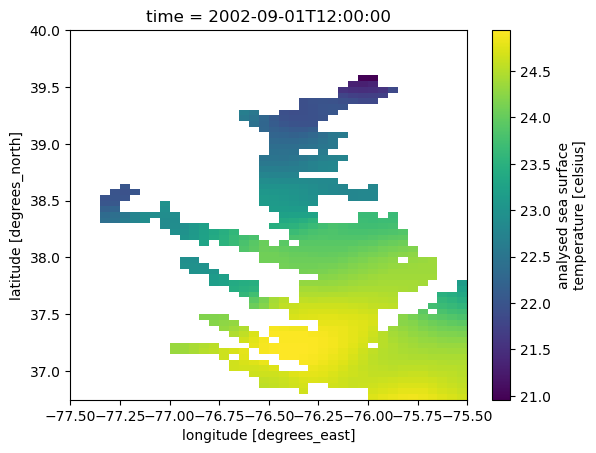

In [13]:
geopolar.isel(time=0).plot()

### Preprocessing

In [14]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(geopolar.time.values)
# Extract numpy array from xarray DataArray
sst_np = geopolar.values

### Identify marine heatwaves with `mhw.detect()` (Geo-Polar)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image.

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in ~4 minutes on my computer.

In [15]:
%%time

result = identify_marineheatwaves(sst_np, time_ordinal)

/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rwegener/repos/chesapeake_mhw/notebooks/01_intermediate_processing/marineHeatWaves.py:281: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rwegener/repos/chesapeake_mhw/notebooks/01_intermediate_processing/marineHeatWaves.py:281: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/repos/chesapeake_mhw/notebooks/01_intermediate_processing/marineHeatWaves.py:281: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/miniconda3/envs/

CPU times: user 10.9 s, sys: 3.75 s, total: 14.6 s
Wall time: 4min 3s


The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [16]:
event_statistics = result[0]

In [17]:
clim_np, thresh_np = extract_numpy_outputs(result, len(time_ordinal))

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save Climatological average and 90th percentile threshold

Create an xarray DataArray for the climatology data using numpy output from the MHW calculation

In [18]:
# create xarray object from numpy output of mhw
clim = xr.DataArray(clim_np, coords=geopolar.coords, dims=geopolar.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'NOAA Geopolar'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [19]:
clim.to_dataset().to_netcdf(os.path.join(OUTPUT_DIR, 'geopolar_climatology_chesapeake.nc'))

Create an xarray DataArray for the threshold data using numpy output from the MHW calculation

In [20]:
thresh = xr.DataArray(thresh_np, coords=geopolar.coords, dims=geopolar.dims)

# rename variables
thresh = thresh.rename('threshold')

# add array attributes
thresh.attrs['comment'] = '90th percentile treshold values computed using the ' \
    'marineHeatWave package. Uses all defaults from .detect() function - 5 day window' \
    ' half width, 31 day smoothing'
thresh.attrs['source_dataset'] = 'NOAA Geopolar'
thresh.attrs['units'] = 'celsius'
thresh.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [21]:
thresh.to_dataset().to_netcdf(os.path.join(OUTPUT_DIR, 'geopolar_threshold_chesapeake.nc'))

### Save the event statistics as a byte stream (pickle) for later processing

In [22]:
path = os.path.join(OUTPUT_DIR, 'mhw_eventstats_dict.pickle')
with open(path, 'wb') as handle:
    pickle.dump(event_statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **Linearly Detrended Geo-Polar SST**

### Open Geo-Polar SST

In [23]:
path = os.path.join(
    REPO_ROOT, 'data/raw', 
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20020901_20230831.nc'
)
geopolar = xr.open_dataset(path).analysed_sst

In [24]:
# convert kelvin to celsius & update metadata
geopolar.values = geopolar.values - 273.15
geopolar.attrs.update({
    'units': 'celsius', 
    'valid_min': geopolar.attrs['valid_min'] - 273.15,
    'valid_max': geopolar.attrs['valid_max'] - 273.15,
})

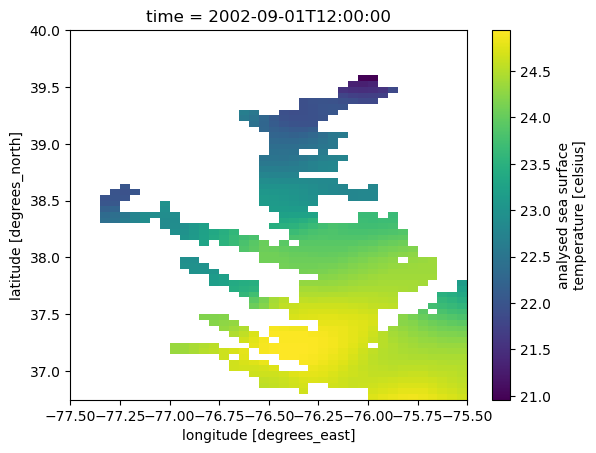

In [25]:
geopolar.isel(time=0).plot()

### Preprocessing

In [26]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(geopolar.time.values)
# Extract numpy array from xarray DataArray
sst_np = geopolar.values

### Detrend the SST data to remove long term warming

In [27]:
%%time

detrended_sst_np = detrend_sst(sst_np, time_ordinal)

CPU times: user 483 ms, sys: 426 ms, total: 909 ms
Wall time: 1.58 s


In [28]:
detrended_sst_np.shape

(7710, 65, 40)

### Identify marine heatwaves with `mhw.detect()` (Linearly detrended Geo-Polar)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image.

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in ~3 minutes on my computer.

In [29]:
%%time

result = identify_marineheatwaves(detrended_sst_np, time_ordinal)

CPU times: user 11.1 s, sys: 3.82 s, total: 15 s
Wall time: 4min 2s


The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [30]:
event_statistics = result[0]

In [31]:
clim_np, _ = extract_numpy_outputs(result, len(time_ordinal))

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save Climatological average and 90th percentile threshold

Create an xarray DataArray for the climatology data using numpy output from the MHW calculation

In [32]:
# create xarray objects from numpy output of mhw
clim = xr.DataArray(clim_np, coords = geopolar.coords, dims=geopolar.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing.' \
    'Input SST was linearly detrended to remove long term warming.'

clim.attrs['source_dataset'] = 'NOAA Geopolar'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [33]:
clim.to_dataset().to_netcdf(os.path.join(OUTPUT_DIR, 'geopolar_climatology_chesapeake_detrended.nc'))

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **MUR SST**

### Open MUR SST

In [34]:
path = os.path.join(
    REPO_ROOT, 'data/raw', 
    'MUR-JPL-L4_GHRSST-SSTfnd-GLOB-v02.0-fv04.1-20020901_20230831.nc'
)
mur = xr.open_dataset(path).analysed_sst

In [35]:
# convert kelvin to celsius & update metadata
mur.values = mur.values - 273.15
mur.attrs.update({
    'units': 'celsius', 
})

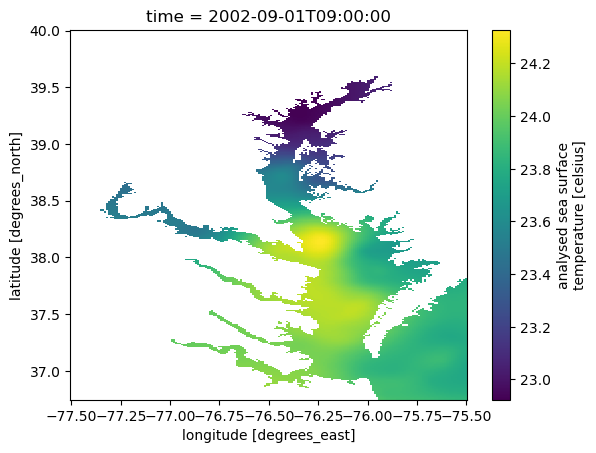

In [36]:
mur.isel(time=0).plot()

### Preprocessing

In [37]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(mur.time.values)
# Extract numpy array from xarray DataArray
sst_np = mur.values

### Identify marine heatwaves with `mhw.detect()` (MUR)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in **XXX** minutes on my computer.

Oh my gosh this took 1 hour and 20 minutes to run for MUR. Good grief.

I guess it is about a linear scale from the Geopolar. 3min for geopolar * 25 times as many grid cells.

In [38]:
%%time

result = identify_marineheatwaves(sst_np, time_ordinal)

CPU times: user 10min 43s, sys: 3min 1s, total: 13min 44s
Wall time: 1h 29min 21s


In [39]:
clim_np, _ = extract_numpy_outputs(result, len(time_ordinal))
# threshold output from MUR is ignored since it is not used

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save climatological average

In [ ]:
# create xarray object from numpy output of mhw
clim = xr.DataArray(clim_np, coords = mur.coords, dims=mur.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'NASA MUR'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [ ]:
path = os.path.join(OUTPUT_DIR, 'mur_climatology_chesapeake.nc')
clim.to_dataset().to_netcdf(path)

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **OSTIA SST**

### Open OSTIA SST

In [ ]:
path = os.path.join(
    REPO_ROOT, 'data/raw', 
    'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_77.47W-75.53W_36.78N-39.97N_2007-01-01-2023-09-01.nc'
)
ostia = xr.open_dataset(path).analysed_sst

In [ ]:
# convert kelvin to celsius & update metadata
ostia.values = ostia.values - 273.15
ostia.attrs.update({
    'units': 'celsius', 
})

In [ ]:
ostia.isel(time=0).plot()

### Preprocessing

In [ ]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(ostia.time.values)
# Extract numpy array from xarray DataArray
sst_np = ostia.values

### Identify marine heatwaves with `mhw.detect()` (OSTIA)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image.

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in 4 minutes on my computer.

In [ ]:
%%time

result = identify_marineheatwaves(sst_np, time_ordinal)

The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [ ]:
event_statistics = result[0]

In [ ]:
clim_np, _ = extract_numpy_outputs(result, len(time_ordinal))
# threshold output from OSTIA is ignored since it is not used

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save climatological average

In [ ]:
# create xarray object from numpy output of mhw
clim = xr.DataArray(clim_np, coords = ostia.coords, dims=ostia.dims)
clim = clim.rename({'latitude': 'lat', 'longitude': 'lon'})

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'Copernicus OSTIA'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [ ]:
clim.to_dataset().to_netcdf(os.path.join(OUTPUT_DIR, 'ostia_climatology_chesapeake.nc'))